# Movie Language Difficulty Classifier

The purpose for this project is to create a machine learning model that can classify movie subtitle difficulty based on the Oxford CEFR ratings.

## Preprocessing/EDA
In order to accomplish this, the subtitles must first be processed in order to correctly match words from the Oxford database. This way only words the match both lists will be scored and words that don't have a rating are not included (this would make the model inefficient).

## Model Training, Hyperparameter tuning, Evaluation
Afterwards merging the two lists, the model can then be created and potentially improved using hyperparameter tuning. The model with the best accuracy score will be recommend for use.

In [ ]:
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# %%shell
# jupyter nbconvert --to html !pip install /content/Apiary_Project.ipynb

In [ ]:
#installing all imports
!pip install catboost
!pip install scikit-learn

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet') 
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import timeit
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics as metrics
import sklearn.preprocessing
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.tree import *

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier


from sklearn.utils import shuffle
from IPython.display import display
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#mounting google drive in order to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#change directory = guiding the program to where the files are
%cd '/content/drive/My Drive/Apiary/Data (old)'
#!ls #shows folder contents

/content/drive/My Drive/Apiary/Data (old)


An SRT file stands for (Subrip Subtitle File) we need to somehow convert it to csv in order to turn it into a dataset.

In [ ]:
!pip install pysrt #reads srt file
!pip install fastparquet #reads parquet file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import modules
import pysrt
import os, time, glob
import io
import pandas as pd
import numpy as np

After importing and having access to the files, the next step is to view a sample of the data and then save it to a dataframe so that we may work with the subtitles.

In [ ]:
for movie_name in glob.glob("*.srt"):
  # Read the srt file
  movie = pysrt.open(movie_name)
  # Extract name value of movie and append to list
  movie_title = movie_name.split('.srt')[0]
  print(movie_title, '\n')
  for subtitles in movie:
    # Extract text from movie
    subtitle_text = subtitles.text
    print(subtitle_text)
  break #stops for loop after the first iteration

10_things_I_hate_about_you(1999) 

Hey!
I'll be right with you.
So, Cameron. Here you go.
Nine schools in 1 0 years.
My, my. Army brat?
-Yeah. My dad is...
-That's enough.
I'm sure you won't find Padua
any different than your old schools.
Same little ass-wipe shit-for-brains
everywhere.
Excuse me? Did you just say...
Am I in the right office?
Not anymore, you're not. I've got
deviants to see and a novel to finish.
Now, scoot. Scoot!
Okay.
Thanks. Thanks a lot.
Patrick Verona.
I see we're making
our visits a weekly ritual.
Only so we can have these moments
together. Should I hit the lights?
Oh, very clever, kangaroo boy.
Says here you exposed yourself
in the cafeteria?
I was joking with the lunch lady.
It was a bratwurst.
Bratwurst?
Aren't we the optimist?
Next time, keep it in your pouch, okay?
Scoot!
Hello! Michael Eckman.
I'm supposed to show you around.
Oh, hi. Thank God. You know...
Normally they send down
one of those audio visual geeks.
No, I do. I know what you mean.
Hey, Michae

After viewing the initial data, how can we organize it? This is were we can transform the data into a dataframe so that we can work with the subtitles.

## Creating the dataframe of movie and subtitles

In this next cell, we are putting the data into a dataframe so that we can work with the subtitles. In the above cell, the subtitles were not organized. Here,

In [ ]:
data = []
for movie_name in glob.glob('*.srt'): #extracting each movie name
    movie = pysrt.open(movie_name)
    movie_title = movie_name.split('.srt')[0]
    for subtitles in movie:
        subtitle_text = subtitles.text #extracting subtitles from each movie
        # Appending movie and subtitle values to data list
        data.append([movie_title, subtitle_text])
df = pd.DataFrame(data, columns= ['movie_title','text']) #creating dataframe with data list and defining columns
df = df.groupby('movie_title')['text'].apply(' '.join).reset_index()

In [ ]:
df

,movie_title,text
0,10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
2,A_knights_tale(2001),Resync: Xenzai[NEF]\nRETAIL Should we help him...
3,A_star_is_born(2018),"- <i><font color=""#ffffff""> Synced and correct..."
4,Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."
...,...,...
81,Twilight(2008),I'd never given much thought\nto how I would d...
82,Up(2009),{\i1}Movietown{\i0}\n{\i1}News presents Spotli...
83,Venom(2018),"<i>Life\nFoundation Control, this is LF1.</i> ..."
84,Warm_bodies(2013),<i>What am I doing</i>\n<i>with my life?</i> <...


In this next cell, we are preprocessing the text so they are in lemmatized form. This gives the subtitles a concise format when we match the Oxford words with the words from the subtitles list. If there are too many versions of a word, it would be very difficult for the model to learn how to predict ratings.

In [ ]:
import re
import spacy
import random
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

corpus = df['text']

def clear_text(text):
    
    pattern = r"[^a-zA-z']" 
    text = re.sub(pattern, " ", str(text)).lower().split()
    text = " ".join(text)
    return text

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemmas=[]
    for w in tokens:
        lemmas.append(lemmatizer.lemmatize(w))
        lemmas.append(" ")
    return "".join(lemmas)

df['text'] = corpus.apply(clear_text)
df['text'] = df['text'].apply(lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# This cell fixes the movie title formatting

#using regex to clean the subtitle data

# df['movie_title'] = df['movie_title'].str.replace(r"\([^)]*\)", '', regex=True)
# #df['movie_title'] = df['movie_title'].str.replace(r'^.*(_)$', ' ', regex=True)
# df['movie_title'] = df['movie_title'].str.replace('_',' ')
# df['text']

After preparing the subtitles, we end up with a list of words in a dataframe that we can use to "match" with our Oxford database. 

In [ ]:
#importing the lemmatized data

lemma_df = pd.read_parquet('/content/Lemmatized_Subtitles.parquet', engine='fastparquet')
lemma_df.columns = [x.lower() for x in lemma_df.columns]
lemma_df

,text,lemma,pos,explain,stopword
0,How,how,SCONJ,subordinating conjunction,True
1,you,you,PRON,pronoun,True
2,doing,do,VERB,verb,True
3,",",",",PUNCT,punctuation,False
4,Keaton,Keaton,PROPN,proper noun,False
...,...,...,...,...,...
50295,Signorina</i,Signorina</i,PROPN,proper noun,False
50296,Franchi,Franchi,PROPN,proper noun,False
50297,Luciano,Luciano,PROPN,proper noun,False
50298,Chapman,Chapman,PROPN,proper noun,False


Here we put all the words in the dataframe into lower case

In [ ]:
#putting all words in lowercase 

for col in lemma_df.columns:
  if col != 'stopword':
    lemma_df[col] = lemma_df[col].apply(lambda x: x.lower())
  else:
    continue

## The Oxford Data

Now that we have our prepared movie subtitles dataframe, we can import our Oxford database words. The listed is separated by CEFR ratings, so each rating will have its' own dataframe to be imported.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving The_Oxford_5000_by_CEFR_level_C1.txt to The_Oxford_5000_by_CEFR_level_C1 (4).txt
Saving The_Oxford_5000_by_CEFR_level_B2.txt to The_Oxford_5000_by_CEFR_level_B2 (4).txt
Saving The_Oxford_3000_by_CEFR_level_B2.txt to The_Oxford_3000_by_CEFR_level_B2 (4).txt
Saving The_Oxford_3000_by_CEFR_level_B1.txt to The_Oxford_3000_by_CEFR_level_B1 (4).txt
Saving The_Oxford_3000_by_CEFR_level_A2.txt to The_Oxford_3000_by_CEFR_level_A2 (4).txt
Saving The_Oxford_3000_by_CEFR_level_A1.txt to The_Oxford_3000_by_CEFR_level_A1 (4).txt


In [ ]:
oxa1 = pd.read_csv('The_Oxford_3000_by_CEFR_level_A1.txt', sep='delimiter')
oxa2 = pd.read_csv('The_Oxford_3000_by_CEFR_level_A2.txt', sep='delimiter')
oxb1 = pd.read_csv('The_Oxford_3000_by_CEFR_level_B1.txt', sep='delimiter')
oxb2 = pd.read_csv('The_Oxford_3000_by_CEFR_level_B2.txt', sep='delimiter')
oxB2 = pd.read_csv('The_Oxford_5000_by_CEFR_level_B2.txt', sep='delimiter')
oxC1 = pd.read_csv('The_Oxford_5000_by_CEFR_level_C1.txt', sep='delimiter')
display(oxa1.head(),
        oxa2.head(),
        oxb1.head(),
        oxb2.head(),
        oxB2.head(),
        oxC1.head())

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,A1
0,"a, an indefinite article"
1,"about prep., adv."
2,"above prep., adv."
3,"across prep., adv."
4,action n.


,A2
0,ability n.
1,able adj.
2,abroad adv.
3,accept v.
4,accident n.


,B1
0,absolutely adv.
1,academic adj.
2,"access n., v."
3,accommodation n.
4,account n.


,B2
0,abandon v.
1,absolute adj.
2,academic n.
3,acceptable adj.
4,accompany v.


,B2
0,absorb v.
1,abstract adj.
2,accent n.
3,accidentally adv.
4,accommodate v.


,C1
0,abolish v.
1,abortion n.
2,absence n.
3,absent adj.
4,absurd adj.


### Processing the Oxford Data

Next, merge all Oxford dataframes into one dataframe in order to eventually create a difficulty level column 'CEFR'.

In [ ]:
#Creating a 'words' column so that I can merge each dataframe on a common column
oxa1 = oxa1.rename(columns={'A1': 'words'})
oxa1['A1'] = 'A1'
oxa2 = oxa2.rename(columns={'A2': 'words'})
oxa2['A2'] = 'A2'
oxb1 = oxb1.rename(columns={'B1': 'words'})
oxb1['B1'] = 'B1'
oxb2 = oxb2.rename(columns={'B2': 'words'})
oxb2['B2'] = 'B2'
oxB2 = oxB2.rename(columns={'B2': 'words'})
oxB2['B2'] = 'B2'
oxC1 = oxC1.rename(columns={'C1': 'words'})
oxC1['C1'] = 'C1'

# #Merging Oxford dataframes (METHOD 1):
oxford = oxa1.merge(oxa2, how='outer').merge(oxb1, how='outer').merge(oxb2, how='outer').merge(oxB2, how='outer').merge(
     oxC1, how='outer')

In [ ]:
oxford.head()

,words,A1,A2,B1,B2,C1
0,"a, an indefinite article",A1,NaN,NaN,NaN,NaN
1,"about prep., adv.",A1,NaN,NaN,NaN,NaN
2,"above prep., adv.",A1,NaN,NaN,NaN,NaN
3,"across prep., adv.",A1,NaN,NaN,NaN,NaN
4,action n.,A1,NaN,NaN,NaN,NaN


Here, we use the melt method to compile all the ratings values into one column (CEFR).

In [ ]:
#Here, we use the melt method to compile all the ratings values into one column (CEFR)
oxford = (oxford.melt(id_vars='words', value_vars = ['A1', 'A2', 'B1', 'B2', 'C1'],
                 value_name='CEFR')
         .drop('variable', axis=1)
         .sort_values('words'))
oxford = oxford.dropna().reset_index(drop=True).sort_index()

In the next cell, I am cleaning up the words column. The parts of speech abbreviations (n., v., adv.) would corrupt the merge process of the subtitle and oxford data later on, since the subtitle words do not contain these abbreviations -- it is just the word.

In [ ]:
oxford['noun'] = oxford['words'].str.extract(r'^.*(n.)$', expand=True)
oxford['verb'] = oxford['words'].str.extract(r'^.*(v.)$', expand=True)
oxford['adjective'] = oxford['words'].str.extract(r'^.*(adj.)$', expand=True)
oxford['adverb'] = oxford['words'].str.extract(r'^.*(adv.)$', expand=True)
oxford['pronoun'] = oxford['words'].str.extract(r'^.*(pron.)$', expand=True)
oxford['preposition'] = oxford['words'].str.extract(r'^.*(prep.)$', expand=True)
oxford['exclamation'] = oxford['words'].str.extract(r'^.*(exclam.)$', expand=True)
oxford['number'] = oxford['words'].str.extract(r'^.*(number)$', expand=True)
oxford['determiner'] = oxford['words'].str.extract(r'^.*(det.)$', expand=True)
oxford['conjunction'] = oxford['words'].str.extract(r'^.*(conj.)$', expand=True)
oxford['indefinite_article'] = oxford['words'].str.extract(r'^.*(indefinite article)$', expand=True)

# .* seems to include characters after the exact match. Best to leave this out after the (word.).

## Oxford Data EDA

Now that the data is processed correctly, we can explore a little bit of the data. I wanted to see if there was any correlation between the parts of speech/word types and the difficulty rating; were some parts of speech found to be more difficult than others? Here, I make a copy of the oxford dataframe so I don't change the original version. This copy is called oxford_hmap (heatmap). I also drop the 'words' column since there are too many unique values, it is not necessary for correlation.

In [ ]:
oxford_hmap = oxford.copy()
oxford_hmap = oxford_hmap.drop(['words'], axis=1)

In [ ]:
oxford_hmap.head()

,CEFR,noun,verb,adjective,adverb,pronoun,preposition,exclamation,number,determiner,conjunction,indefinite_article
0,B2,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A1,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A1,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A1,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A1,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using the Label Encoder to transform missing values so we can create the heatmap.

In [ ]:
oxford_hmap = oxford_hmap.apply(LabelEncoder().fit_transform)
oxford_hmap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5263 entries, 0 to 5262
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   CEFR                5263 non-null   int64
 1   noun                5263 non-null   int64
 2   verb                5263 non-null   int64
 3   adjective           5263 non-null   int64
 4   adverb              5263 non-null   int64
 5   pronoun             5263 non-null   int64
 6   preposition         5263 non-null   int64
 7   exclamation         5263 non-null   int64
 8   number              5263 non-null   int64
 9   determiner          5263 non-null   int64
 10  conjunction         5263 non-null   int64
 11  indefinite_article  5263 non-null   int64
dtypes: int64(12)
memory usage: 493.5 KB


Creating the correlation matrix and the heatmap.

Text(0.5, 1.0, 'Correlation between the variables')

<Figure size 1440x1440 with 0 Axes>

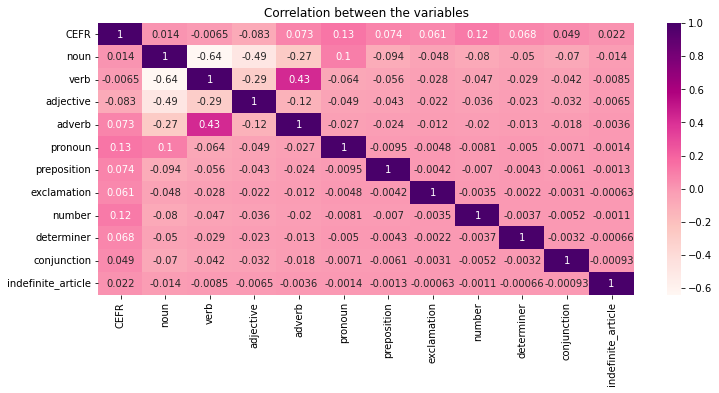

In [ ]:
#correlation matrix and the heatmap
corrmat = oxford_hmap.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.subplots(figsize=(12,5))
#plot heat map
ax = sns.heatmap(corrmat, annot=True, cmap='RdPu')
plt.title('Correlation between the variables')

## Heatmap Findings:

1) According to the CEFR column of the heatmap, there was not any particular word type that led to higher or lower difficulty ratings.

2) This was determined because many of the values in the CEFR heatmap column are found in the middle of the heat scale, being barely above and below 0.0.

In [ ]:
oxford.head(1)

,words,CEFR,noun,verb,adjective,adverb,pronoun,preposition,exclamation,number,determiner,conjunction,indefinite_article
0,AIDS n.,B2,n.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Continuing to preprocess the oxford data

Here, we go back to the original oxford dataframe and collect all the parts of speech column into one column 'pos'. I also replace the abbreviated versions with the the full name (n. = noun)so it matches the subtitle 'explain' column values. This is to better ensure a smoother merge.

In [ ]:
# .* seems to include characters after the exact match. Best to leave this out after the (word.).
oxford = (oxford.melt(id_vars=['words', 'CEFR'], value_vars = ['noun', 'verb', 'adjective', 'adverb', 'pronoun', 'preposition', 
                                                     'exclamation', 'number', 'determiner', 'conjunction', 'indefinite_article'], 
                      value_name='pos').drop('variable', axis=1).sort_values('words'))

oxford = oxford.dropna().drop_duplicates(subset=['words']).reset_index(drop=True).sort_index()

#changing the 'type' values to match the subtitle data values for smoother data merging
oxford['pos'] = oxford['pos'].replace(['n.','v.', 'adj.', 'adv.', 'pron.', 'prep.', 'exclam.', 'number', 'det.', 'conj.',
                                               'indefinite article'], ['noun', 'verb', 'adjective', 'adverb', 'pronoun', 'preposition', 
                                                     'exclamation', 'number', 'determiner', 'conjunction', 'indefinite_article'])

In [ ]:
oxford['words'] = oxford['words'].str.replace(r"\w*\.\w*", '', regex=True) #removing any word connected via period (word-types)
oxford['words'] = oxford['words'].str.replace(r".(, )$", '', regex=True) #removing commas and space
oxford['words'] = oxford['words'].str.replace(r".(indefinite article)$", '', regex=True)

In [ ]:
#value counts for all columns in df

# for c in oxford.columns:
#     if c != 'words':
#         print(f"{c}: \n\n{oxford[c].value_counts()}\n")

## Combining subtitle and oxford dataframes

Now that we have completed the preprocessed the oxford data, we can import it the data and start merging the subtitle and oxford dataframe.

In [ ]:
oxford_AB = pd.read_parquet('/content/Oxford_Data_A_B.parquet', engine='fastparquet')
oxford_C = pd.read_parquet('/content/Oxford_C_Level.parquet', engine='fastparquet')

# Keep only data that is needed
oxford_AB = oxford_AB[['headword','pos','CEFR']].drop_duplicates()
oxford_C = oxford_C[['headword','pos','CEFR']].drop_duplicates()

# Combined both A/B and C level data
oxford_data = pd.concat([oxford_AB, oxford_C]).drop_duplicates().reset_index(drop=True)
oxford_data.sample(3)


,headword,pos,CEFR
1265,colorful/colourful,adjective,A2
4398,myth,noun,B1
9640,cognitive,adjective,C2


In [ ]:
# Remove any potential duplicate values
lemma_df = lemma_df.drop_duplicates()
oxford_data = oxford_data.drop_duplicates()

# Let's join lemma_df with oxford_df on headword/pos, and text/explain
combined_df = lemma_df.merge(oxford_data, how='left', left_on=['text', 'explain'], 
                       right_on=['headword', 'pos'], validate='m:m')
print(combined_df.shape)

(44117, 8)


Here, we can see that we have missing values. These need to be replaced and we can use the mode.

In [ ]:
combined_df = combined_df.drop_duplicates()
print(combined_df.shape)

(44117, 8)


In this next cell, we can see that the missing values were successfully filled in and there are no missing values present in the dataframe.

In [ ]:
combined_df = combined_df.fillna(combined_df['CEFR'].value_counts().index[0])

combined_df.isna().mean() * 100

#creating missing values report
report = combined_df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / combined_df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
text,0,0.0
lemma,0,0.0
pos_x,0,0.0
explain,0,0.0
stopword,0,0.0
headword,0,0.0
pos_y,0,0.0
CEFR,0,0.0


In [ ]:
combined_df.columns

Index(['text', 'lemma', 'pos_x', 'explain', 'stopword', 'headword', 'pos_y',
       'CEFR'],
      dtype='object')

Now that the missing values have been filled in, it is time to transform the target into a numeric value so that it may be used to train the model. The model would not be able to train if it was still in word formatting.

In [ ]:
# Now that we have each word as it's own row let's tokenize the data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
combined_df['CEFRs'] = labelencoder.fit_transform(combined_df['CEFR'])

print(combined_df['CEFRs'].value_counts())

2    39861
3     1573
1     1181
0      966
4      359
5      177
Name: CEFRs, dtype: int64


## Creating the models

Now we can finally start building the models. In this cell, we define the features and targets. The features are what the model will learn in order to predict the target value, which is CEFR rating or the difficulty. This data needs to be split into 80:20 -- the model learns 80% and is tested on 20%. After the models are scored, we end up with accuracy scores for three different models

In [ ]:
# Setup random seed
# np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier

# Define different features and transformer pipelines
categorical_features = ['pos_x', 'explain',	'stopword',	'pos_y'] #left out features with too many unique values like "lemma" and "headword"
categorical_transformer = Pipeline(steps=[
      ("imputer", SimpleImputer(strategy="most_frequent")),  #fill_value="missing"
      ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)])


# Create a preprocessing and modelling pipeline
model_1 = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model_1", RandomForestClassifier())])

model_2 = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model_2", KNeighborsClassifier())])

model_3 = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model_3", LogisticRegression())])

# Let's drop unwnated columns first and split into X & y
X = combined_df[['pos_x', 'explain',	'stopword',	'pos_y']]
y = combined_df['CEFRs']

# Now split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, 
                                                    random_state=42)

# Fit and score the model
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

kn_score = model_1.score(X_test, y_test)
rfc_score = model_2.score(X_test, y_test)
lr_score = model_3.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Text(0.5, 0, 'Models')

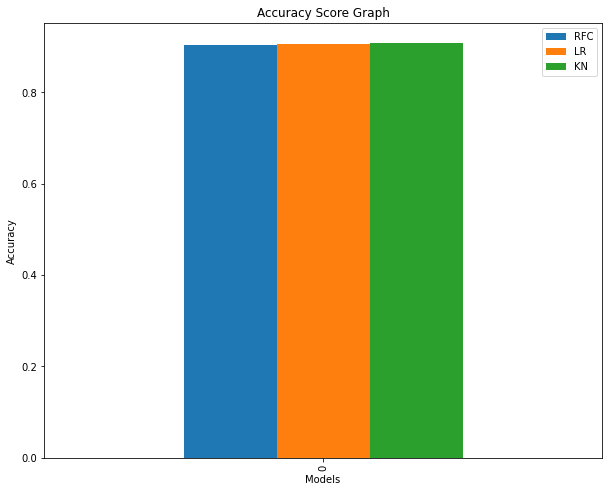

In [ ]:
compare_metrics = pd.DataFrame({'RFC':rfc_score,
                                'LR':lr_score,
                                'KN':kn_score}, index=[0])

compare_metrics.plot.bar(figsize=(10,8))
plt.title('Accuracy Score Graph')
plt.ylabel('Accuracy')
plt.xlabel('Models')

In [ ]:
print(kn_score, rfc_score, lr_score)

0.9071849501359928 0.9038984587488668 0.9063916591115141


## Default Models Bar Chart Findings:

1) Models are performing similarly, but the knn model is slightly better. We can try hyperparameter tuning to see if this will help the model.

## Hyperparameter Tuning

In this cell, we tune the knn model. The model continually evaluated with a validation set of the data for each number in the range of 1-30 n_neighbors. n_neighbors lets the model know how many "neighbors" the model should consider when predicting the values.

In [ ]:
%%time
#fitting new model
knn = KNeighborsClassifier()
param_grid = {'model__n_neighbors': np.arange(1, 31)}

pipe = Pipeline(steps=[("preprocessor", preprocessor), 
                ("model", knn)])

#estimated time ~ 15-16min.
grid = GridSearchCV(pipe, param_grid, scoring='f1_micro', return_train_score=False,verbose=1)

grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 15min 19s, sys: 14.4 s, total: 15min 33s
Wall time: 15min 30s


Plotting the cross-validation results to see how the model had progressed.

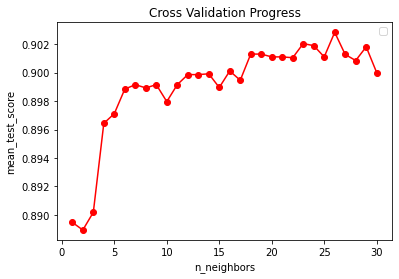

In [ ]:
scores_df = pd.DataFrame(grid.cv_results_)
#scores_features = scores_df[['param_model__n_neighbors', 'mean_test_score']]
#plt.plot(scores_features)
plt.plot(scores_df['param_model__n_neighbors'], scores_df['mean_test_score'], color='red', marker='o')
plt.legend()
plt.title('Cross Validation Progress')
plt.xlabel('n_neighbors')
plt.ylabel('mean_test_score')
plt.show()

In [ ]:
print(grid_search.best_params_)

{'model__n_neighbors': 26}


## Cross Validation Progress Graph

1) The best value to use for n_neighbors was 26.

2) We can see that the mean_test_score improved graduatlly from 6 - 26 n_neighbors, but starts to decline afterwards.

Now that we have the best parameters for the model, we can score it and add it to our scores dataframe for all the models created so far.

In [ ]:
knn_best = Pipeline(steps=[("preprocessor", preprocessor),
                        ("knn_best", KNeighborsClassifier(n_neighbors=26))])

knn_best.fit(X_train, y_train)
knn_best_score = knn_best.score(X_test, y_test)
compare_metrics['knn_best_score'] = knn_best_score

We can repeat a similar process for another model to tune. This will be a different type of model so it will have different hyperparameters to tune.

In [ ]:
%%time
#fitting new logistic regression model
lr = LogisticRegression()

import warnings
warnings.filterwarnings('ignore')

# parameter grid
param_grid = {
    'model__penalty' : ['l1','l2'], 
    'model__C'       : np.logspace(-3,3,7),
    'model__solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

pipe = Pipeline(steps=[("preprocessor", preprocessor), 
                ("model", lr)])

# estimated time ~ 15-16min.
lr_grid = GridSearchCV(pipe, param_grid, scoring='f1_micro', return_train_score=False,verbose=1)

lr_grid_search = lr_grid.fit(X_train, y_train)

In [ ]:
lr_scores_df = pd.DataFrame(lr_grid.cv_results_)
print(lr_grid_search.best_params_)

Now we can evaluate the new logistic regression model and added it to our scores dataframe and visualize it to see how it compares to the other models.

In [ ]:
lr_best = Pipeline(steps=[("preprocessor", preprocessor),
                        ("lr_best", LogisticRegression(C=0.01, solver='liblinear'))])

lr_best.fit(X_train, y_train)
lr_best_score = lr_best.score(X_test, y_test)
compare_metrics['lr_best_score'] = lr_best_score

compare_metrics.plot.bar(figsize=(10,8))
plt.title('Final Accuracy Score Graph')
plt.ylabel('Accuracy')
plt.xlabel('Models')

In [ ]:
compare_metrics

## Conclusion

1) The most accurate model for classifying subtitle difficulty was the KNearestNeighbors model (0.907).

2) In the cases of both tuning the KNN and LR models, the results were worse than the default models. Hyperparameter tuning is useful, but sometimes the default settings are better suited.

3) All models performed very similarly; none of the scores deviated by more than 0.1 from eachother.